# Preprare configs

This notebook supports the process of preparing config files.
The goals of the notebooks are as follows:
- extract selected frame(s) from the video
- define and test unwrapping parameters (camera view -> bird's eye view)    //! unclear what unwrapping params are what these two views are for
- define brid-eye to map transition parameters                              //! transition parameters from normal camera view to birds eye?
- check the lane mask

In [6]:
### Importing packages (!# why this order / separation)
import sys
#! Set directory to ./MoveOver directory; parent directory of example folder
sys.path.insert(0,'..')

import os
import cv2
import pathlib 
import pickle
import config
import numpy as np
from moveoverlib.functions import *
import matplotlib.pyplot as plt
# Displays plots in the Jupyter notebook
%matplotlib inline

array([[[235, 235, 235],
        [251, 251, 251],
        [244, 244, 244],
        ...,
        [249, 212, 204],
        [249, 212, 204],
        [249, 212, 204]],

       [[246, 246, 246],
        [252, 252, 252],
        [243, 243, 243],
        ...,
        [249, 212, 204],
        [249, 212, 204],
        [249, 212, 204]],

       [[243, 243, 243],
        [239, 239, 239],
        [255, 255, 255],
        ...,
        [249, 212, 204],
        [249, 212, 204],
        [249, 212, 204]],

       ...,

       [[129, 120, 130],
        [129, 120, 130],
        [129, 120, 130],
        ...,
        [ 37,  74,  66],
        [ 35,  73,  65],
        [ 35,  73,  65]],

       [[129, 120, 130],
        [129, 120, 130],
        [129, 120, 130],
        ...,
        [ 32,  72,  62],
        [ 34,  72,  63],
        [ 35,  73,  65]],

       [[129, 120, 130],
        [129, 120, 130],
        [129, 120, 130],
        ...,
        [ 30,  69,  60],
        [ 34,  72,  63],
        [ 37,  74,  66]]

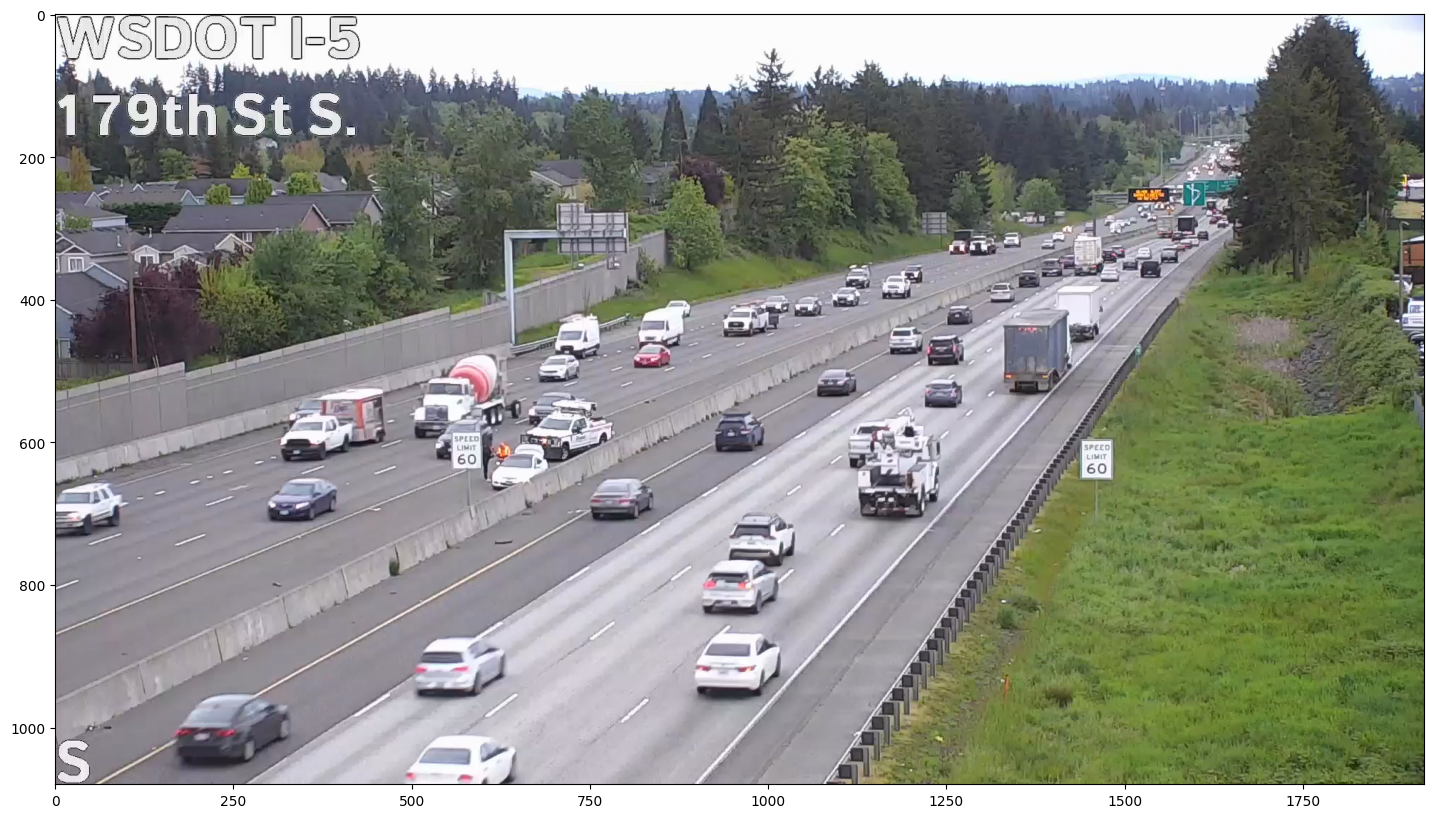

In [7]:
# Create /data folder within ./MoveOver/example
pathlib.Path(config.DATA_PATH).mkdir(parents=True, exist_ok=True) 

#! Not sure where this is - in the CATT-Works parent repo?
#! No videos folder in repo
VIDEO_FILE = '../../videos/vid_source.mp4'

# Write binary version of video to new ./data folder
pickle.dump(VIDEO_FILE, open(f'{config.DATA_PATH}/videopath.p', 'wb'))

# Create ./images folder for images within ./MoveOver/example
pathlib.Path('./images/').mkdir(parents=True, exist_ok=True)

# Extract frames from video and save in ./images
#! Why (0*60)*15
extractFrame(VIDEO_FILE, frameno = (0*60)*15, dest_file = './images/frame_view1.jpg')

Points for source (camera view) and destination (image view)
First four points are used for unwrapping, the rest is just display at tests

In [8]:
#! Where these points manually found? Is this example specific?
#! What are the points exactly?
#! Diff between camera view (SRC) and image view (DST)?
#! Doesn't use sign
##!! needs to be done for each camera by dispatchers?
SRC = np.float32([
    [581, 727], # Left speed limit
    [1458, 717], # Right speed limit
    [800, 430], # Left railing
    [1578, 411], # Right railing
    [643, 474], # Sign
])

DST = np.float32([
    [206, 29], # Left speed limit
    [41, 75], # Right speed limit
    [567, 925], # Left railing
    [287, 1170], # Right railing
    [543, 724], # Sign
])


print ('  "cameraPoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],'.format(
    int(SRC[0][0]), int(SRC[0][1]),
    int(SRC[1][0]), int(SRC[1][1]),
    int(SRC[2][0]), int(SRC[2][1]),
    int(SRC[3][0]), int(SRC[3][1])
))

print ('  "birdEyePoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],'.format(
    int(DST[0][0]), int(DST[0][1]),
    int(DST[1][0]), int(DST[1][1]),
    int(DST[2][0]), int(DST[2][1]),
    int(DST[3][0]), int(DST[3][1]),
))

  "cameraPoints" : [[581, 727], [1458, 717], [800, 430], [1578, 411]],
  "birdEyePoints" : [[206, 29], [41, 75], [567, 925], [287, 1170]],


In [9]:
#! Seems like it's creating the mapping from camera to bird's eye?
#! What is M and what is Minv? Mapping matricies?
M = cv2.getPerspectiveTransform(SRC[:4], DST[:4])
Minv = cv2.getPerspectiveTransform(DST[:4], SRC[:4])

[581. 727.] -> [206.  29.]
[1458.  717.] -> [41. 75.]
[800. 430.] -> [567. 925.]
[1578.  411.] -> [ 287. 1170.]
[643. 474.] -> [510.00674 668.3886 ]


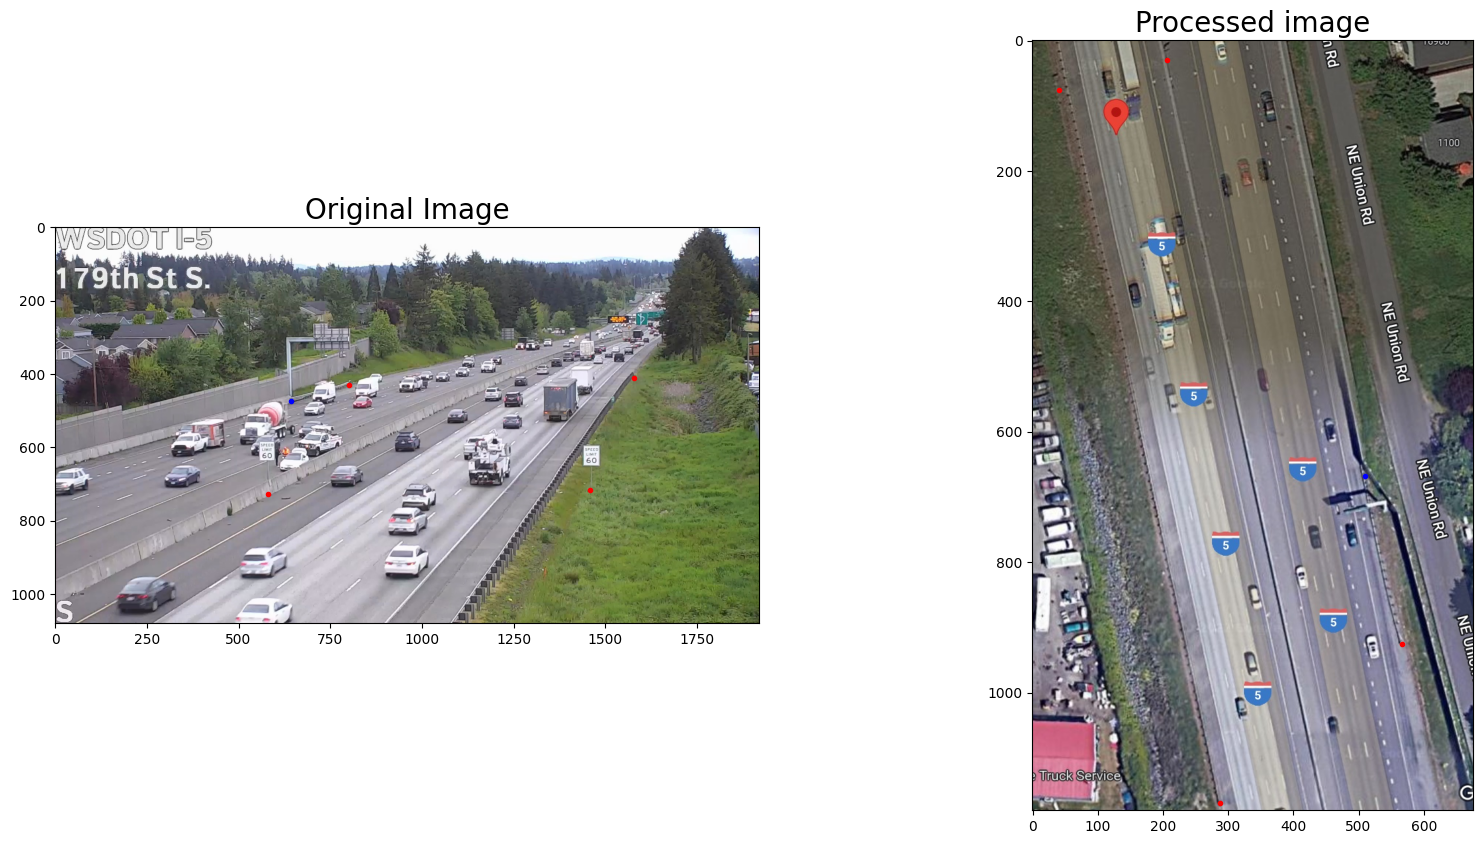

In [10]:
# Show points on original camera and transformed bird's eye
map_file = './images/SkyView.jpg'
ret = displayPoints(SRC, M, './images/frame_view1.jpg', map_file)

[206.  29.] -> [581. 727.]
[41. 75.] -> [1458.  717.]
[567. 925.] -> [800. 430.]
[ 287. 1170.] -> [1578.  411.]
[543. 724.] -> [629.1995  462.14673]


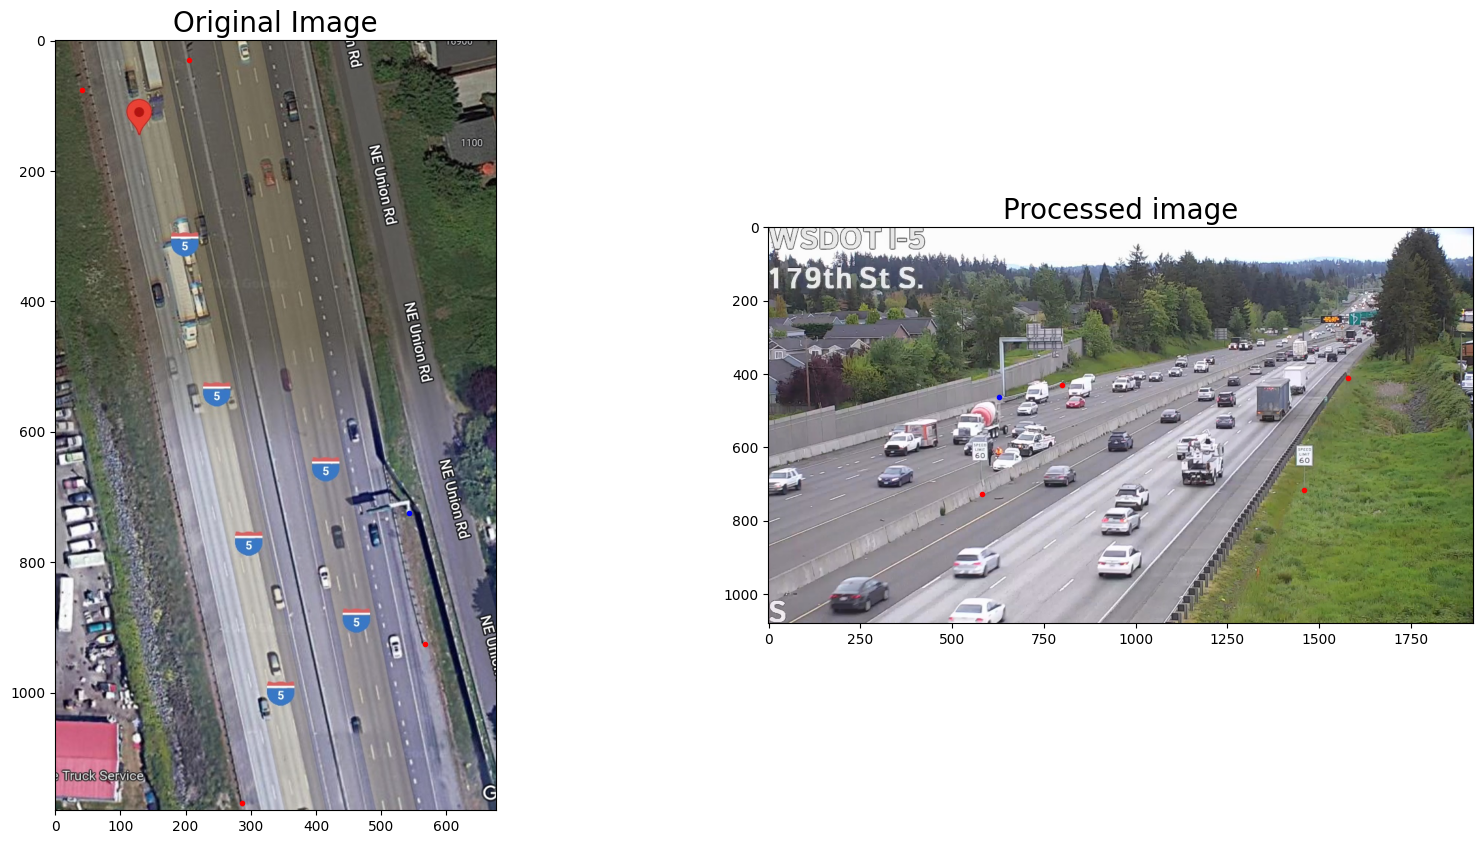

In [11]:
#! Not sure yet
ret = displayPoints(DST, Minv, map_file,  './images/frame_view1.jpg')

# SkyView 2 Geocoordinates

In [12]:
#! What are these
latlon1 = 45.743893, -122.660828
xy1 = 96, 30
latlon2 = 45.742497, -122.659864
xy2 = 635, 1151

# Lane masks

(array([  0,  26,  51,  77, 102, 128, 153]), array([1942776,    5086,   12723,   31641,    9935,   22446,   48993]))
OK! Mask parameers defined correctly in params.json.


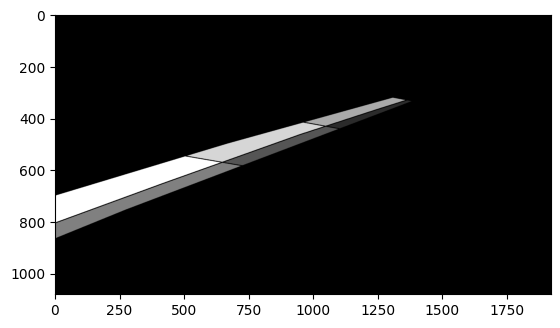

In [13]:
#! Is this also done ahead of time manually?
MASK_PATH = './images/mask.png'

#! Where is this mystery directory - MoveOver Repo?
sys.path.insert(0,'../..')
from cav.parameters import Parameters
#! Don't fully understand the params in the json
#! Seems used for transforming from camera to bird's eye
params = Parameters()
params.generateParameters('./params.json')

#! Why *255
mask = (255*plt.imread(MASK_PATH)).astype(int)
#! No blue?
if (len(mask.shape) == 3) and (mask.shape[2] > 1):
    #mask = np.sum(mask, axis=2)
    mask = mask[:, :, 0]
plt.imshow(mask, cmap='gray')
#! Why use unique?
unique = np.unique(mask, return_counts=True)
print (unique)

#! Premade test? Don't understand how lane_mask and unique are related
#! How was lane_mask found?
if [0] + params.lanes_mask == sorted(unique[0]):
    print ('OK! Mask parameers defined correctly in params.json.')
else:
    print (f'json file : {[0] + params.lanes_mask}')
    print (f'from image : {sorted(unique)}')
    

### Create json file

In [14]:
#! Writes json file, but uses the json file in cells above?
#! Seems like frame_view1 and SkyView aren't modified and are given ahead of time
img = cv2.imread('./images/frame_view1.jpg')
skyview = cv2.imread('./images/SkyView.jpg')

jsonfile = '''{{
  "videoShape" : [{}, {}],
  "birdEyeViewShape" : [{}, {}],

  "cameraPoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],
  "birdEyePoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],

  "birdEyeCoordinates" : [[{}, {}], [{}, {}]],
  "latLonCoordinates" : [[{}, {}], [{}, {}]],
  "elevation" : 40,
    
  "lanes_mask" : {}
}}'''.format(
    img.shape[1], img.shape[0], # videoShape
    skyview.shape[1], skyview.shape[0], # birdEyeViewShape
    
    int(SRC[0][0]), int(SRC[0][1]), # cameraPoints
    int(SRC[1][0]), int(SRC[1][1]),
    int(SRC[2][0]), int(SRC[2][1]),
    int(SRC[3][0]), int(SRC[3][1]), # cameraPointsEnd 
    
    int(DST[0][0]), int(DST[0][1]), # birdEyePoints
    int(DST[1][0]), int(DST[1][1]),
    int(DST[2][0]), int(DST[2][1]),
    int(DST[3][0]), int(DST[3][1]), # birdEyePointsEnd
    
    xy1[0], xy1[1], xy2[0], xy2[1], #birdEyeCoordinates

    latlon1[1], latlon1[0], #latLonCoordinates
    latlon2[1], latlon2[0],
    
    str(sorted(unique[0])[1:]), # lanes_mask
)

with open('params.json', 'w') as f:
    for line in jsonfile.split('\n'):
        print (line)
        f.write(line + '\n')



{
  "videoShape" : [1920, 1080],
  "birdEyeViewShape" : [676, 1181],

  "cameraPoints" : [[581, 727], [1458, 717], [800, 430], [1578, 411]],
  "birdEyePoints" : [[206, 29], [41, 75], [567, 925], [287, 1170]],

  "birdEyeCoordinates" : [[96, 30], [635, 1151]],
  "latLonCoordinates" : [[-122.660828, 45.743893], [-122.659864, 45.742497]],
  "elevation" : 40,
    
  "lanes_mask" : [26, 51, 77, 102, 128, 153]
}
